# Model Comparison on Excluded Classes

This notebook compares the performance of a standard object detection model against a hierarchical model on classes that were explicitly excluded from the training dataset.

**Hypothesis:** The hierarchical model will be able to make more informed predictions on unseen classes by leveraging the class hierarchy, predicting a parent or ancestor class instead of failing completely.

**Methodology:**
1.  **Configure Models:** Specify the paths to the model configs and inference results for the models trained with class exclusions.
2.  **Process Data:** Load the prediction results and calculate the hierarchical prediction distribution for each class.
3.  **Select Classes:** Define a list of classes to analyze, focusing on the ones excluded from training.
4.  **Visualize Comparison:** Generate bar charts to compare the prediction distributions of the two models for the selected classes.

## Project Setup

The following cell adds the project's root directory to the Python path to ensure that modules from the `tools` and `hod` directories can be imported.

In [3]:
import sys
import os

# Add project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

os.chdir(project_root)

In [4]:
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mmengine import Config
from mmengine.registry import init_default_scope
from mmdet.registry import DATASETS
from collections import defaultdict
import warnings

# Suppress specific warnings if necessary
warnings.filterwarnings("ignore", category=UserWarning, message=".*Creating a tensor from a list of numpy.ndarrays is slow.*")

# Initialize the default scope for MMDetection
init_default_scope('mmdet')

## 1. Configuration

**Action Required:** Update the `MODELS_TO_ANALYZE` dictionary with the models you wish to compare. The keys should be descriptive names, and the values should be dictionaries containing the paths to the model's configuration file and the inference results (`.pkl` file).

In [10]:
MODELS_TO_ANALYZE = {
    # "DINO-Flat": {
    #     "config": "configs/hod/models/dino/dino-r50_improved_8xb2-36e_aircraft-func.py",
    #     "results_path": "outputs/inference/dino-r50_improved_8xb2-36e_aircraft-func.pkl"
    # },
    "DINO-Flat-Excluded": {
        "config": "configs/hod/models/dino/dino-r50_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64.py",
        "results_path": "outputs/inference/dino-r50_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64.pkl"
    },
    "DINO-E-Excluded:": {
        "config": "configs/hod/models/embedding_dino/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64.py",
        "results_path": "outputs/inference/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64.pkl"
    },
    "DINO-H-Excluded": {
        "config": "configs/hod/models/hierarchical_dino/hi_dino-r50-hfl10-ecl-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64.py",
        "results_path": "outputs/inference/hi_dino-r50-hfl10-ecl-sep-eucl_improved_8xb2-36e_aircraft-func-excluded-F16.Mig29.B1.C130.TB2.AH64.pkl"
    },
    # "DINO-H": {
    #     "config": "configs/hod/models/hierarchical_dino/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func.py",
    #     "results_path": "outputs/inference/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func.pkl"
    # }
}

## 2. Helper Functions

These functions are imported from the analysis tools to process the raw prediction data.

In [11]:
from tools.analysis_tools.hierarchical_prediction_distribution import (
    calculate_confusion_matrix,
    calculate_hierarchical_prediction_distribution
)

## 3. Data Processing

This section loads the results for each model, calculates the hierarchical statistics per class, and compiles them into a single DataFrame.

In [12]:
all_class_stats = []

for model_name, model_info in MODELS_TO_ANALYZE.items():
    print(f"Processing model: {model_name}...")
    
    config_path = model_info['config']
    results_path = Path(model_info['results_path'])
    
    if not results_path.exists():
        print(f"  WARNING: Results file not found, skipping: {results_path}")
        continue
        
    # Load config and build dataset
    cfg = Config.fromfile(config_path)
    dataset = DATASETS.build(cfg.test_dataloader.dataset)
    
    # Load results
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
        
    # Calculate stats
    confusion_matrix = calculate_confusion_matrix(dataset, results, score_thr=0.3, tp_iou_thr=0.5)
    hierarchical_stats = calculate_hierarchical_prediction_distribution(dataset, confusion_matrix)
    
    # Store stats for each class
    for class_name, stats in hierarchical_stats.items():
        s = stats.copy()
        s['model'] = model_name
        s['class_name'] = class_name
        all_class_stats.append(s)

# Create DataFrame
df_class = pd.DataFrame(all_class_stats)

print("\nProcessing complete.")
if not df_class.empty:
    print("DataFrame created with the following columns:")
    print(df_class.columns)
else:
    print("No data was processed. Please check your `MODELS_TO_ANALYZE` configuration.")

Processing model: DINO-Flat-Excluded...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1295/1295, 3413.7 task/s, elapsed: 0s, ETA:     0s[                                                  ] 0/1295, elapsed: 0s, ETA:Processing model: DINO-E-Excluded:...
[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1295/1295, 3413.7 task/s, elapsed: 0s, ETA:     0sProcessing model: DINO-E-Excluded:...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1295/1295, 3602.6 task/s, elapsed: 0s, ETA:     0s[                                                  ] 0/1295, elapsed: 0s, ETA:Processing model: DINO-H-Excluded...
[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1295/1295, 3602.6 task/s, elapsed: 0s, ETA:     0sProcessing model: DINO-H-Excluded...
loading annotations into memory...
loading annotations into memory...
Done (t=0.01s)
crea

In [13]:
df_class.head()

,total_gt,tp,parent_tp,grandparent_tp,sibling_tp,cousin_tp,ancestor_tp,distance,fn,tp_percentage,...,grandparent_percentage,sibling_percentage,cousin_percentage,ancestor_percentage,fn_percentage,other_class_percentage,avg_distance,other_class,model,class_name
0,2297.0,1383.0,0.0,0.0,185.0,174.0,0.0,0.0,301.0,60.208968,...,0.0,8.053983,7.575098,0.0,13.104049,11.057902,0.0,254.0,DINO-Flat-Excluded,Total
1,56.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,80.357143,...,0.0,0.000000,0.000000,0.0,12.500000,7.142857,0.0,4.0,DINO-Flat-Excluded,A10
2,34.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,76.470588,...,0.0,0.000000,0.000000,0.0,11.764706,11.764706,0.0,4.0,DINO-Flat-Excluded,A400M
3,16.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,56.250000,...,0.0,0.000000,0.000000,0.0,31.250000,12.500000,0.0,2.0,DINO-Flat-Excluded,AG600
4,35.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,11.0,0.000000,...,0.0,57.142857,0.000000,0.0,31.428571,11.428571,0.0,4.0,DINO-Flat-Excluded,AH64


## 4. Comparative Visualization

This section generates bar charts to compare the models' performance on specific classes.

### Define Classes for Analysis

**Action Required:** Modify the `CLASSES_TO_PLOT` list to include the class names you want to visualize. These should be the classes that were excluded during training.

In [14]:
CLASSES_TO_PLOT = ['F16', 'Mig29', 'B1', 'C130', 'TB2', 'AH64', 'Total']

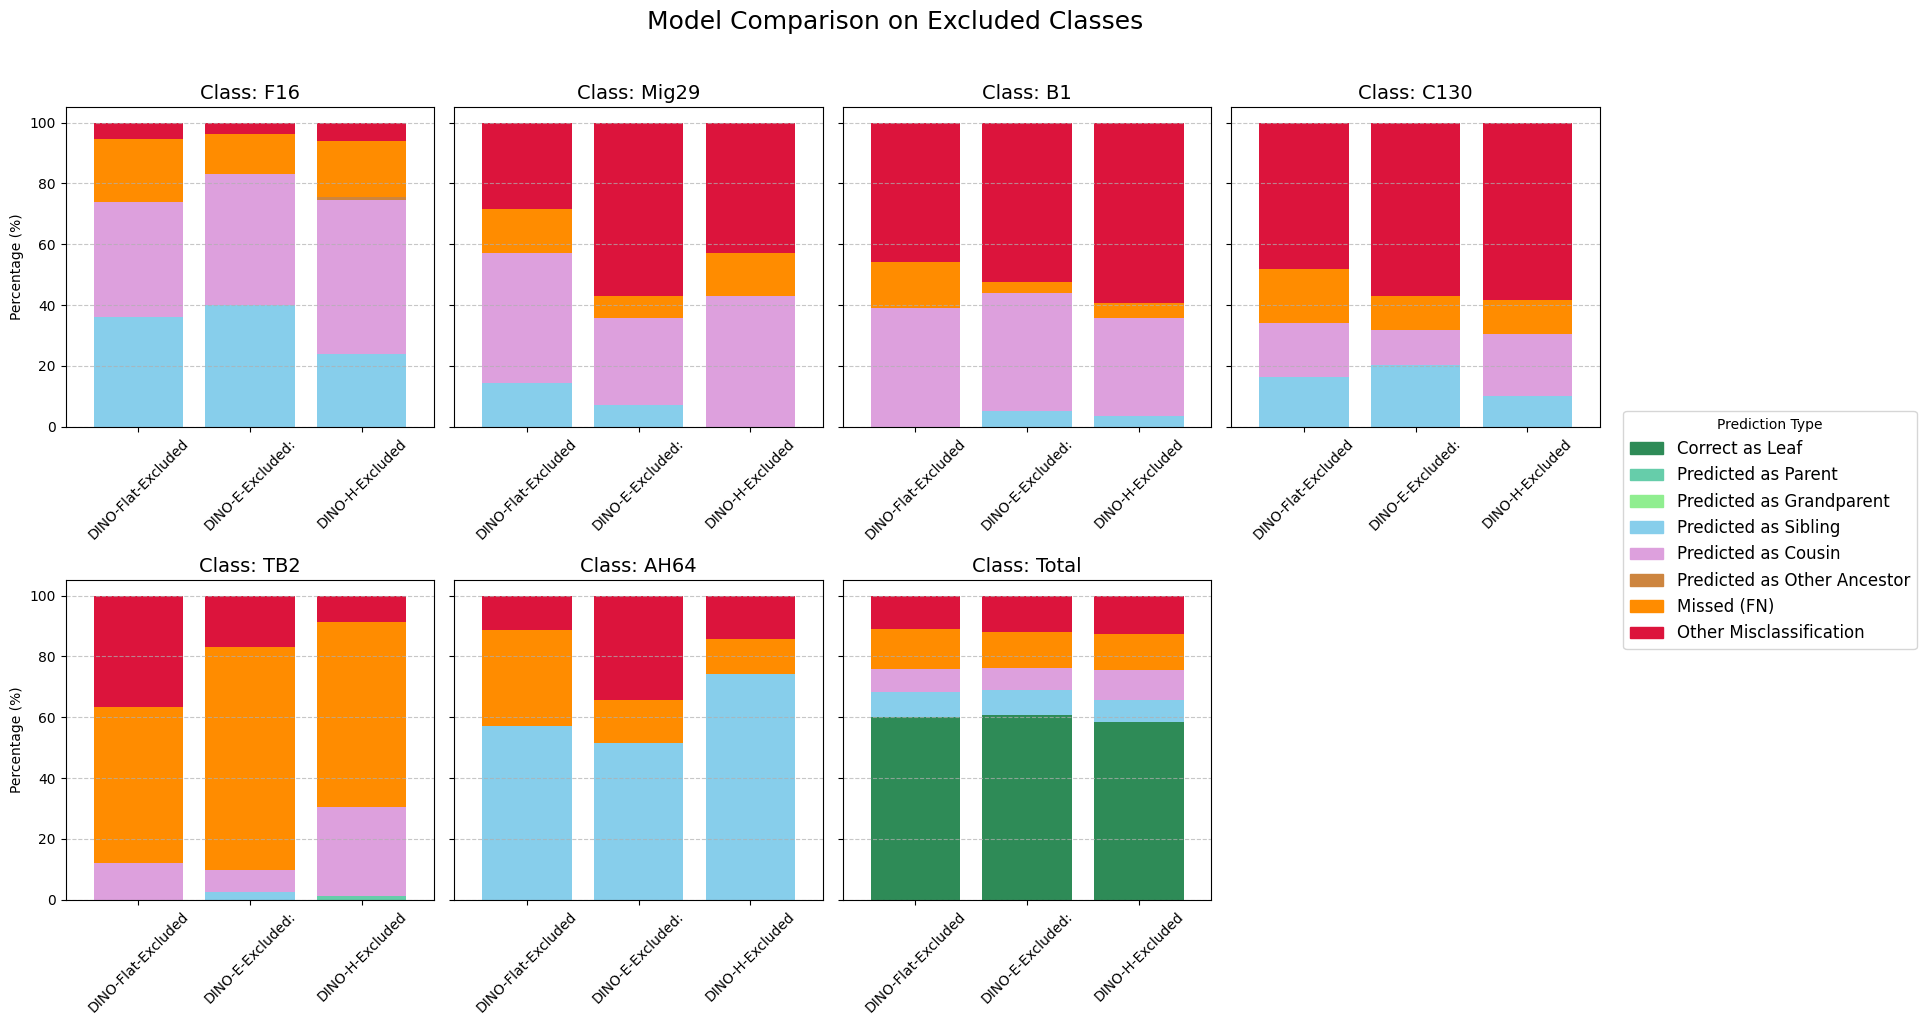

In [15]:
if not df_class.empty:
    # Define the order, labels, and colors for plotting
    plot_order = [
        'tp_percentage', 
        'parent_percentage', 
        'grandparent_percentage', 
        'sibling_percentage', 
        'cousin_percentage', 
        'ancestor_percentage', 
        'fn_percentage', 
        'other_class_percentage'
    ]
    
    plot_labels = {
        'tp_percentage': 'Correct as Leaf',
        'parent_percentage': 'Predicted as Parent',
        'grandparent_percentage': 'Predicted as Grandparent',
        'sibling_percentage': 'Predicted as Sibling',
        'cousin_percentage': 'Predicted as Cousin',
        'ancestor_percentage': 'Predicted as Other Ancestor',
        'fn_percentage': 'Missed (FN)',
        'other_class_percentage': 'Other Misclassification'
    }

    plot_colors = {
        'tp_percentage': '#2E8B57',
        'parent_percentage': '#66CDAA',
        'grandparent_percentage': '#90EE90',
        'sibling_percentage': '#87CEEB',
        'cousin_percentage': '#DDA0DD',
        'ancestor_percentage': '#CD853F',
        'fn_percentage': '#FF8C00',
        'other_class_percentage': '#DC143C'
    }
    color_list = [plot_colors[p] for p in plot_order]

    # Filter the DataFrame to only include the selected classes
    df_plot = df_class[df_class['class_name'].isin(CLASSES_TO_PLOT)]
    
    # --- Create Stacked Bar Chart ---
    
    # Setup plot grid
    num_classes = len(CLASSES_TO_PLOT)
    num_cols = 4 # More columns for a compact view
    num_rows = (num_classes + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows), sharey=True)
    axes = axes.flatten()

    for i, class_name in enumerate(CLASSES_TO_PLOT):
        ax = axes[i]
        
        # Filter data for the current class
        df_class_specific = df_plot[df_plot['class_name'] == class_name].copy()
        
        # Set model as index for plotting
        df_to_plot = df_class_specific.set_index('model')[plot_order]

        # Skip plotting if there is no data for this class
        if df_to_plot.empty:
            ax.set_title(f"Class: {class_name} (No Data)", fontsize=12)
            ax.set_visible(False)
            continue
        
        # Plot stacked bar with narrower bars
        df_to_plot.plot(kind='bar', stacked=True, ax=ax, color=color_list, legend=False, width=0.8)
        
        ax.set_title(f"Class: {class_name}", fontsize=14)
        ax.set_ylabel("Percentage (%)")
        ax.set_xlabel("") # Model names are on the x-ticks
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        axes[i].set_visible(False)

    # Create a single, shared legend
    handles = [plt.Rectangle((0,0),1,1, color=plot_colors[label]) for label in plot_order]
    legend_labels = [plot_labels[l] for l in plot_order]
    fig.legend(handles, legend_labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=12, title="Prediction Type")

    fig.suptitle('Model Comparison on Excluded Classes', fontsize=18, y=1.02)
    fig.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend
    plt.show()

else:
    print("DataFrame is empty. Cannot generate plots.")

In [16]:
# get df with class = Total
df_total = df_class[df_class['class_name'] == 'Total'].copy()
df_total

,total_gt,tp,parent_tp,grandparent_tp,sibling_tp,cousin_tp,ancestor_tp,distance,fn,tp_percentage,...,grandparent_percentage,sibling_percentage,cousin_percentage,ancestor_percentage,fn_percentage,other_class_percentage,avg_distance,other_class,model,class_name
0,2297.0,1383.0,0.0,0.0,185.0,174.0,0.0,0.0,301.0,60.208968,...,0.0,8.053983,7.575098,0.000000,13.104049,11.057902,0.0,254.0,DINO-Flat-Excluded,Total
82,2297.0,1397.0,0.0,0.0,184.0,170.0,0.0,0.0,273.0,60.818459,...,0.0,8.010448,7.400958,0.000000,11.885067,11.885067,0.0,273.0,DINO-E-Excluded:,Total
164,2297.0,1339.0,2.0,0.0,167.0,224.0,3.0,17.0,275.0,58.293426,...,0.0,7.270353,9.751850,0.130605,11.972138,12.494558,3.4,287.0,DINO-H-Excluded,Total
